### IMPORTING LIBRARIES AND DATASETS

In [411]:
import pandas as pd
import graphviz
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import math
import numpy as np
from sklearn.model_selection import train_test_split
import pickle
import xgboost as xgb
%matplotlib inline

In [412]:
properties = pd.read_csv('properties.csv')
reviews = pd.read_csv('reviews.csv')
queries = pd.read_csv('queries.csv')
interactions =pd.read_csv('interactions.csv')

### EXPLORATORY DATA ANALYSIS (EDA) 

In [413]:
properties.columns

Index(['property_id', 'city_id', 'country_id', 'property_type',
       'distance_to_center'],
      dtype='object')

In [414]:
reviews.sort_values(by='date_stayed', ascending=False)

,property_id,date_stayed,age_group,trip_type,security_score,location_score,staff_score,fun_score,cleanliness_score,value_for_money_score,facilities_score
613012,8635,2019-12-29,25-30,Regular Vacation,5,5,5,5,5,5,5
85933,14322,2019-12-29,18-24,RTW Trip,5,5,5,5,5,5,5
412734,2478,2019-12-29,18-24,RTW Trip,5,5,5,4,4,5,5
7603,20916,2019-12-29,31-40,REGULARVACATION,3,4,4,3,2,2,3
7606,8868,2019-12-29,25-30,Weekend Away,5,5,4,4,5,5,5
...,...,...,...,...,...,...,...,...,...,...,...
8641,13436,2018-06-03,25-30,GAPYEAR,5,5,5,5,5,5,5
457391,8810,2018-06-03,18-24,GAPYEAR,5,4,4,5,4,5,4
287710,17725,2018-06-03,25-30,REGULARVACATION,5,5,5,5,5,5,5
406796,19929,2018-06-01,25-30,OTHER,1,3,1,1,1,1,1


In [462]:
queries.head()

,query_id,device_type,language,checkin_date,checkout_date,nr_guests,city_id,date_time
0,109397,desktop,english,2019-12-28,2019-12-31,2,4583,2019-12-17 21:41:34
1,109572,desktop,english,2020-01-05,2020-01-07,6,4799,2019-12-14 08:07:37
2,109484,desktop,other,2020-01-22,2020-01-23,1,5560,2019-12-17 15:12:09
3,109365,mobile,english,2019-12-26,2019-12-28,1,3518,2019-12-22 20:44:31
4,94059,mobile,english,2020-01-07,2020-01-08,2,364,2019-12-27 09:25:56


In [416]:
print(properties.shape)
print(reviews.shape)
print(queries.shape)
print(interactions.shape)

(21202, 5)
(649055, 11)
(500000, 8)
(5976498, 6)


### DATA PREPARATION 

#### JOINING DATAFRAMES

In [417]:
#JOIN queries x interactions
new=queries.join(interactions.set_index('query_id'),on='query_id')

In [418]:
new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5979611 entries, 0 to 499999
Data columns (total 13 columns):
 #   Column         Dtype  
---  ------         -----  
 0   query_id       int64  
 1   device_type    object 
 2   language       object 
 3   checkin_date   object 
 4   checkout_date  object 
 5   nr_guests      int64  
 6   city_id        int64  
 7   date_time      object 
 8   property_id    int64  
 9   position       int64  
 10  interaction    object 
 11  dorm_price     float64
 12  private_price  float64
dtypes: float64(2), int64(5), object(6)
memory usage: 638.7+ MB


In [419]:
new_ordenated=new.sort_values(by='dorm_price', ascending=False)

In [420]:
new=new.reset_index(drop=True)

In [421]:
new.tail()

,query_id,device_type,language,checkin_date,checkout_date,nr_guests,city_id,date_time,property_id,position,interaction,dorm_price,private_price
5979606,362096,desktop,english,2019-12-12,2019-12-13,1,6620,2019-12-05 09:31:23,16126,12,VIEW,11.9,9.9
5979607,362096,desktop,english,2019-12-12,2019-12-13,1,6620,2019-12-05 09:31:23,20733,7,BOOKING,4.3,20.8
5979608,362096,desktop,english,2019-12-12,2019-12-13,1,6620,2019-12-05 09:31:23,19216,3,VIEW,11.9,10.9
5979609,362096,desktop,english,2019-12-12,2019-12-13,1,6620,2019-12-05 09:31:23,20522,2,VIEW,11.9,10.9
5979610,362096,desktop,english,2019-12-12,2019-12-13,1,6620,2019-12-05 09:31:23,7399,10,VIEW,15.0,NaN


In [422]:
#AVOID COLUMN OVERLAP
properties_tmp = properties.drop(columns=['city_id'])

In [423]:
#JOIN new x properties
new2=new.join(properties_tmp.set_index('property_id'),on='property_id')
new2.tail()

,query_id,device_type,language,checkin_date,checkout_date,nr_guests,city_id,date_time,property_id,position,interaction,dorm_price,private_price,country_id,property_type,distance_to_center
5979606,362096,desktop,english,2019-12-12,2019-12-13,1,6620,2019-12-05 09:31:23,16126,12,VIEW,11.9,9.9,57.0,1.0,0.2
5979607,362096,desktop,english,2019-12-12,2019-12-13,1,6620,2019-12-05 09:31:23,20733,7,BOOKING,4.3,20.8,57.0,1.0,1.5
5979608,362096,desktop,english,2019-12-12,2019-12-13,1,6620,2019-12-05 09:31:23,19216,3,VIEW,11.9,10.9,57.0,1.0,0.2
5979609,362096,desktop,english,2019-12-12,2019-12-13,1,6620,2019-12-05 09:31:23,20522,2,VIEW,11.9,10.9,57.0,1.0,0.5
5979610,362096,desktop,english,2019-12-12,2019-12-13,1,6620,2019-12-05 09:31:23,7399,10,VIEW,15.0,NaN,57.0,1.0,1.8


In [424]:
reviews.head()

,property_id,date_stayed,age_group,trip_type,security_score,location_score,staff_score,fun_score,cleanliness_score,value_for_money_score,facilities_score
0,15563,2019-06-12,18-24,REGULARVACATION,4,5,4,5,3,5,4
1,15074,2019-06-04,18-24,OTHER,5,5,5,5,4,5,5
2,21078,2019-10-26,18-24,WEEKENDAWAY,3,5,5,4,4,4,4
3,12179,2019-10-20,18-24,GAPYEAR,5,5,5,5,5,5,5
4,21314,2019-10-26,31-40,REGULARVACATION,3,4,3,3,2,4,2


In [425]:
reviews.property_id.value_counts()

17725    2022
15553    1777
21762    1612
14030    1554
4989     1495
         ... 
579         1
8263        1
5075        1
17033       1
10599       1
Name: property_id, Length: 15449, dtype: int64

In [426]:
reviews_temp = reviews.groupby(by='property_id',as_index=False).mean()
reviews_temp

,property_id,security_score,location_score,staff_score,fun_score,cleanliness_score,value_for_money_score,facilities_score
0,3,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
1,8,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
2,9,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
3,14,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
4,17,5.000000,5.000000,4.000000,5.000000,5.000000,5.000000,5.000000
...,...,...,...,...,...,...,...,...
15444,21860,4.666667,4.500000,4.833333,5.000000,4.666667,5.000000,4.666667
15445,21861,4.000000,3.666667,4.000000,3.000000,3.666667,3.833333,3.166667
15446,21862,4.076923,4.576923,4.423077,3.692308,3.846154,3.653846,3.423077
15447,21863,4.600000,4.600000,4.600000,3.800000,4.200000,4.400000,3.400000


In [427]:
#JOIN new2 x reviews
new3=new2.join(reviews_temp.set_index('property_id'),on='property_id')
new3.tail()
data = new3 

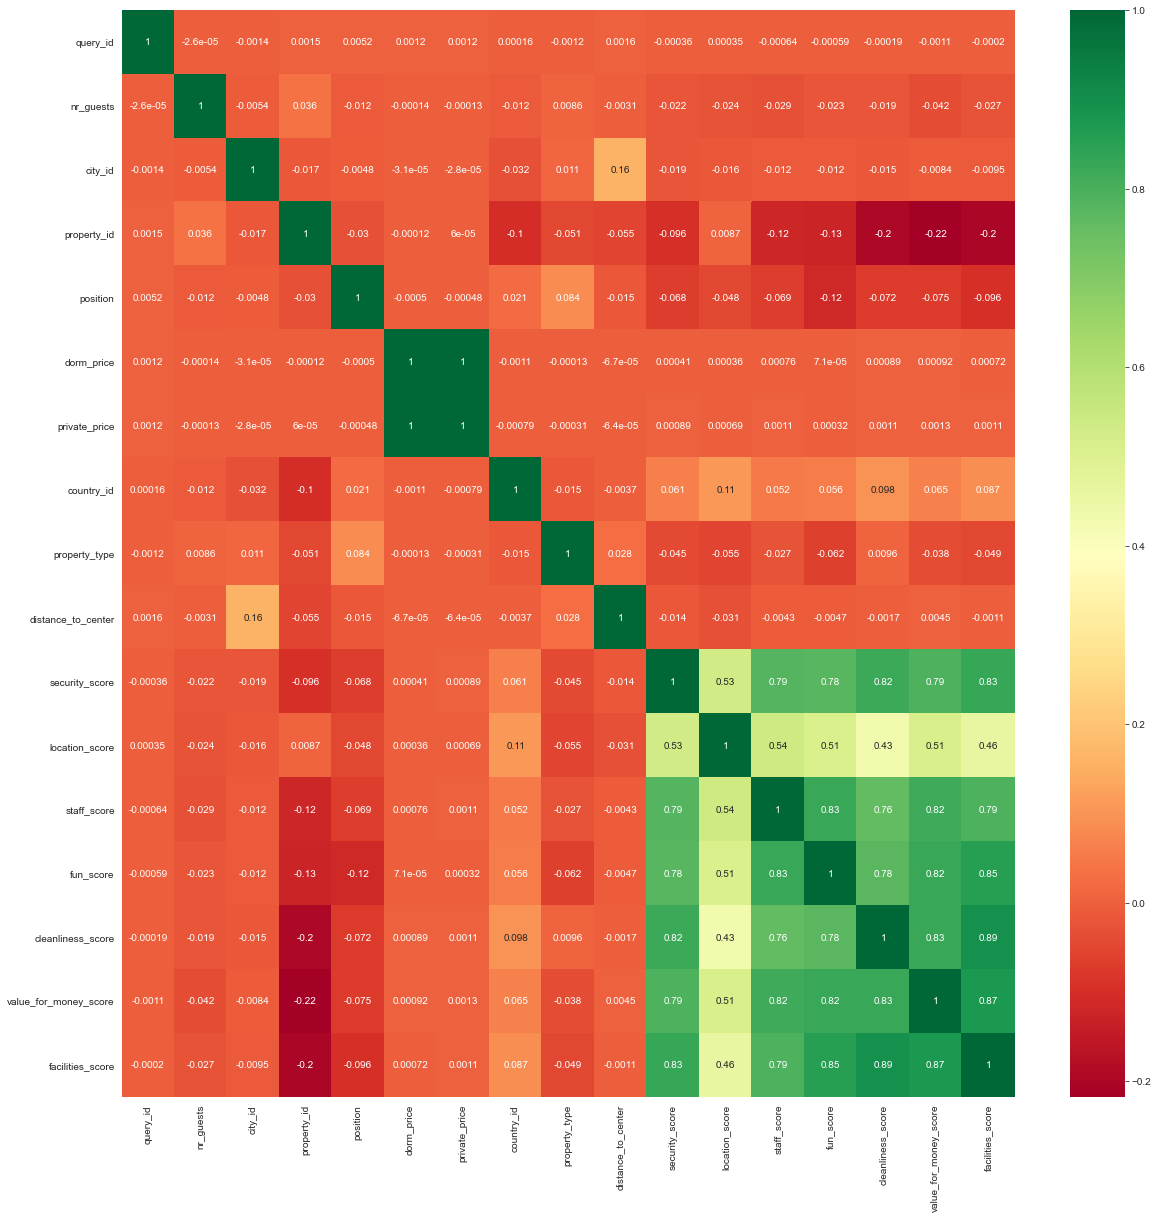

In [428]:
import seaborn as sns
corrmat = data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(data.corr(),annot=True,cmap="RdYlGn")

Remove variables with correlation> | 0.9 | other variables and variables with> 90% of empty values

In [429]:
data.isna().sum()

query_id                      0
device_type                   0
language                      0
checkin_date                  0
checkout_date                 0
nr_guests                     0
city_id                       0
date_time                     0
property_id                   0
position                      0
interaction                   0
dorm_price               806745
private_price            985310
country_id                18835
property_type             18835
distance_to_center        18835
security_score           272770
location_score           272770
staff_score              272770
fun_score                272770
cleanliness_score        272770
value_for_money_score    272770
facilities_score         272770
dtype: int64

#### OUTLIERS DETECTION

In [430]:
display(data.describe().apply(lambda s: s.apply('{0:.5f}'.format)))

,query_id,nr_guests,city_id,property_id,position,dorm_price,private_price,country_id,property_type,distance_to_center,security_score,location_score,staff_score,fun_score,cleanliness_score,value_for_money_score,facilities_score
count,5979611.00000,5979611.00000,5979611.00000,5979611.00000,5979611.00000,5172866.00000,4994301.00000,5960776.00000,5960776.00000,5960776.00000,5706841.00000,5706841.00000,5706841.00000,5706841.00000,5706841.00000,5706841.00000,5706841.00000
mean,249907.87863,2.04012,7489.59912,13488.69693,8.43843,142.99534,129.14216,125.12072,1.22025,30.51448,4.40144,4.42247,4.39643,4.06401,4.17795,4.23528,4.07531
std,144266.39902,1.70421,77362.49508,6175.38086,7.40596,94453.60567,96051.69780,68.90582,0.59713,541.10674,0.47635,0.46534,0.47989,0.57676,0.61326,0.51784,0.59542
min,1.00000,1.00000,40.00000,1.00000,1.00000,0.00000,0.00000,2.00000,1.00000,0.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000
25%,124895.00000,1.00000,1776.00000,8438.00000,4.00000,9.80000,13.90000,67.00000,1.00000,1.00000,4.22305,4.20408,4.20000,3.78947,3.91557,4.00000,3.79598
50%,249880.00000,2.00000,4694.00000,14331.00000,7.00000,15.00000,22.20000,108.00000,1.00000,1.80000,4.50714,4.53030,4.49398,4.16296,4.30254,4.32258,4.20000
75%,374949.00000,2.00000,6700.00000,19083.00000,11.00000,22.60000,33.70000,194.00000,1.00000,4.30000,4.70000,4.74900,4.71875,4.44776,4.60714,4.58333,4.49354
max,499739.00000,80.00000,3113155.00000,21864.00000,424.00000,117496000.00000,117496000.00000,245.00000,5.00000,15941.10000,5.00000,5.00000,5.00000,5.00000,5.00000,5.00000,5.00000


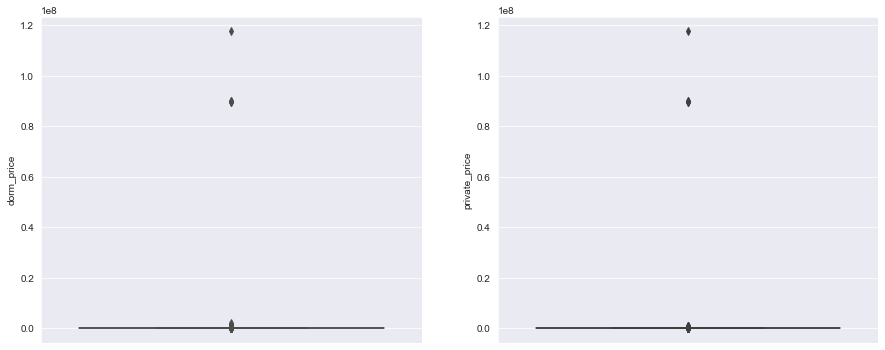

In [431]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.boxplot(y=data['dorm_price'], color="red")
plt.subplot(1,2,2)
sns.boxplot(y=data['private_price'])
plt.show()

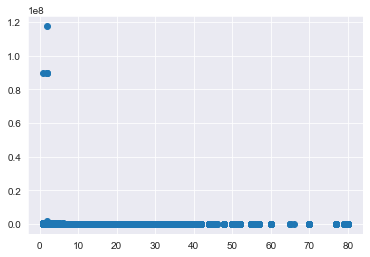

In [432]:
plt.scatter(x=data['nr_guests'],y=data['dorm_price'])
plt.show()

In [433]:
data['dorm_price'].sort_values(ascending=False)

1483492    117496000.0
900952      89956000.0
4064418     89875000.0
2271153     89699000.0
130375      89699000.0
              ...     
5979569            NaN
5979576            NaN
5979580            NaN
5979590            NaN
5979593            NaN
Name: dorm_price, Length: 5979611, dtype: float64

<AxesSubplot:>

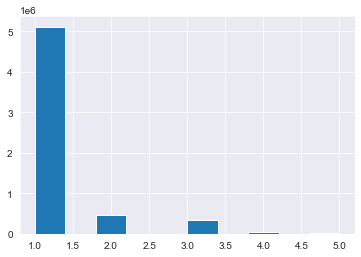

In [434]:
data['property_type'].hist()

In [435]:
data['nr_guests'].value_counts().head()

2    2571490
1    2359214
3     434689
4     309467
5     119172
Name: nr_guests, dtype: int64

In [436]:
data['interaction'].value_counts()

VIEW       5387754
CLICK       567659
BOOKING      24198
Name: interaction, dtype: int64

<function matplotlib.pyplot.show(close=None, block=None)>

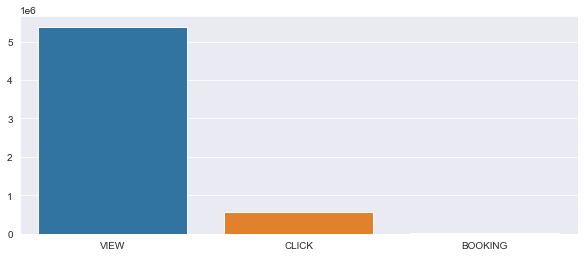

In [437]:
import seaborn as sns
import matplotlib.pyplot as plt
classes = data.interaction.value_counts()
sns.set_style("darkgrid")
plt.figure(figsize=(10,4))
sns.barplot(x=classes.index, y=classes.values)
plt.show

#### ENCODE CATEGORICAL DATA

In [438]:
#LABEL ENCODING
X_cat = data.select_dtypes(include=['object'])
#X_enc = X_cat.copy()
#DEPOIS TRABALHAR COM O DATETIME. POR HORA EXCLUIR
X_cat=X_cat.drop(columns=["checkin_date","checkout_date","date_time"])
X_cat.columns

Index(['device_type', 'language', 'interaction'], dtype='object')

In [439]:
X_enc = pd.get_dummies(X_cat)
X_enc.head()

,device_type_desktop,device_type_mobile,language_english,language_french,language_german,language_other,language_spanish,interaction_BOOKING,interaction_CLICK,interaction_VIEW
0,1,0,1,0,0,0,0,0,0,1
1,1,0,1,0,0,0,0,0,0,1
2,1,0,1,0,0,0,0,0,0,1
3,1,0,1,0,0,0,0,0,0,1
4,1,0,1,0,0,0,0,0,0,1


In [440]:
data=pd.concat([data,X_enc], axis=1)
#DROP COLUMNS ALREADY ENCODED
data = data.drop(columns=['device_type', 'language', 'interaction'])
data.tail()

,query_id,checkin_date,checkout_date,nr_guests,city_id,date_time,property_id,position,dorm_price,private_price,...,device_type_desktop,device_type_mobile,language_english,language_french,language_german,language_other,language_spanish,interaction_BOOKING,interaction_CLICK,interaction_VIEW
5979606,362096,2019-12-12,2019-12-13,1,6620,2019-12-05 09:31:23,16126,12,11.9,9.9,...,1,0,1,0,0,0,0,0,0,1
5979607,362096,2019-12-12,2019-12-13,1,6620,2019-12-05 09:31:23,20733,7,4.3,20.8,...,1,0,1,0,0,0,0,1,0,0
5979608,362096,2019-12-12,2019-12-13,1,6620,2019-12-05 09:31:23,19216,3,11.9,10.9,...,1,0,1,0,0,0,0,0,0,1
5979609,362096,2019-12-12,2019-12-13,1,6620,2019-12-05 09:31:23,20522,2,11.9,10.9,...,1,0,1,0,0,0,0,0,0,1
5979610,362096,2019-12-12,2019-12-13,1,6620,2019-12-05 09:31:23,7399,10,15.0,NaN,...,1,0,1,0,0,0,0,0,0,1


In [441]:
#CHECKING DATA CLASS BALANCE
data['interaction_BOOKING'].value_counts()

0    5955413
1      24198
Name: interaction_BOOKING, dtype: int64

#### ADD MORE FEATURES

In [442]:
#EXTRACTING MORE FEATURES - DATETIME

def featurize_df(data:pd.DataFrame) ->pd.DataFrame:

    data["weekday"] = data["date_time"].dt.weekday
    data["week_of_year"] = data["date_time"].dt.week

    data["hour"] = data["date_time"].dt.hour
    data["minute"] = data["date_time"].dt.minute
    ## total time elapsed - allows model to learn continous trend over time to a degree
    data["early_night"] = ((data["hour"]>19) | (data["hour"]<3)) # no added value from feature    
#   data["nans_count"] = data.isna().sum(axis=1)
    
    return data

data["date_time"] = pd.to_datetime(data["date_time"],infer_datetime_format=True)
# featurization must be after leaky cols are dropped, otherwise the nan feature will bea leak!

display(data.describe().apply(lambda s: s.apply('{0:.5f}'.format)))

,query_id,nr_guests,city_id,property_id,position,dorm_price,private_price,country_id,property_type,distance_to_center,...,device_type_desktop,device_type_mobile,language_english,language_french,language_german,language_other,language_spanish,interaction_BOOKING,interaction_CLICK,interaction_VIEW
count,5979611.00000,5979611.00000,5979611.00000,5979611.00000,5979611.00000,5172866.00000,4994301.00000,5960776.00000,5960776.00000,5960776.00000,...,5979611.00000,5979611.00000,5979611.00000,5979611.00000,5979611.00000,5979611.00000,5979611.00000,5979611.00000,5979611.00000,5979611.00000
mean,249907.87863,2.04012,7489.59912,13488.69693,8.43843,142.99534,129.14216,125.12072,1.22025,30.51448,...,0.55263,0.44737,0.70258,0.04132,0.04274,0.11069,0.10267,0.00405,0.09493,0.90102
std,144266.39902,1.70421,77362.49508,6175.38086,7.40596,94453.60567,96051.69780,68.90582,0.59713,541.10674,...,0.49722,0.49722,0.45712,0.19903,0.20226,0.31375,0.30353,0.06349,0.29312,0.29863
min,1.00000,1.00000,40.00000,1.00000,1.00000,0.00000,0.00000,2.00000,1.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
25%,124895.00000,1.00000,1776.00000,8438.00000,4.00000,9.80000,13.90000,67.00000,1.00000,1.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000
50%,249880.00000,2.00000,4694.00000,14331.00000,7.00000,15.00000,22.20000,108.00000,1.00000,1.80000,...,1.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000
75%,374949.00000,2.00000,6700.00000,19083.00000,11.00000,22.60000,33.70000,194.00000,1.00000,4.30000,...,1.00000,1.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000
max,499739.00000,80.00000,3113155.00000,21864.00000,424.00000,117496000.00000,117496000.00000,245.00000,5.00000,15941.10000,...,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000


In [443]:
data = featurize_df(data)
data.tail()

/anaconda3/envs/Elux_NLP/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


,query_id,checkin_date,checkout_date,nr_guests,city_id,date_time,property_id,position,dorm_price,private_price,...,language_other,language_spanish,interaction_BOOKING,interaction_CLICK,interaction_VIEW,weekday,week_of_year,hour,minute,early_night
5979606,362096,2019-12-12,2019-12-13,1,6620,2019-12-05 09:31:23,16126,12,11.9,9.9,...,0,0,0,0,1,3,49,9,31,False
5979607,362096,2019-12-12,2019-12-13,1,6620,2019-12-05 09:31:23,20733,7,4.3,20.8,...,0,0,1,0,0,3,49,9,31,False
5979608,362096,2019-12-12,2019-12-13,1,6620,2019-12-05 09:31:23,19216,3,11.9,10.9,...,0,0,0,0,1,3,49,9,31,False
5979609,362096,2019-12-12,2019-12-13,1,6620,2019-12-05 09:31:23,20522,2,11.9,10.9,...,0,0,0,0,1,3,49,9,31,False
5979610,362096,2019-12-12,2019-12-13,1,6620,2019-12-05 09:31:23,7399,10,15.0,NaN,...,0,0,0,0,1,3,49,9,31,False


In [444]:
data.columns

Index(['query_id', 'checkin_date', 'checkout_date', 'nr_guests', 'city_id',
       'date_time', 'property_id', 'position', 'dorm_price', 'private_price',
       'country_id', 'property_type', 'distance_to_center', 'security_score',
       'location_score', 'staff_score', 'fun_score', 'cleanliness_score',
       'value_for_money_score', 'facilities_score', 'device_type_desktop',
       'device_type_mobile', 'language_english', 'language_french',
       'language_german', 'language_other', 'language_spanish',
       'interaction_BOOKING', 'interaction_CLICK', 'interaction_VIEW',
       'weekday', 'week_of_year', 'hour', 'minute', 'early_night'],
      dtype='object')

#### SET TARGET

In [445]:
X = data.copy()
#X = X.dropna()
X = X.reset_index(drop=True)
#DROP CATEGORICAL COLUMNS checkin_date, checkout_date, date_time
Y = X['interaction_BOOKING']
X = X.drop(columns=['checkin_date','checkout_date','date_time','query_id','interaction_BOOKING',
            'interaction_CLICK','interaction_VIEW'])

In [446]:
X.columns

Index(['nr_guests', 'city_id', 'property_id', 'position', 'dorm_price',
       'private_price', 'country_id', 'property_type', 'distance_to_center',
       'security_score', 'location_score', 'staff_score', 'fun_score',
       'cleanliness_score', 'value_for_money_score', 'facilities_score',
       'device_type_desktop', 'device_type_mobile', 'language_english',
       'language_french', 'language_german', 'language_other',
       'language_spanish', 'weekday', 'week_of_year', 'hour', 'minute',
       'early_night'],
      dtype='object')

In [447]:
print(X.shape)
print(Y.shape)

(5979611, 28)
(5979611,)


In [448]:
X

,nr_guests,city_id,property_id,position,dorm_price,private_price,country_id,property_type,distance_to_center,security_score,...,language_english,language_french,language_german,language_other,language_spanish,weekday,week_of_year,hour,minute,early_night
0,2,4583,6436,17,8.1,11.5,174.0,1.0,7.6,3.818182,...,1,0,0,0,0,1,51,21,41,True
1,2,4583,1536,19,7.1,9.0,174.0,1.0,7.3,2.500000,...,1,0,0,0,0,1,51,21,41,True
2,2,4583,20708,27,NaN,9.1,174.0,1.0,7.9,4.810811,...,1,0,0,0,0,1,51,21,41,True
3,2,4583,18470,26,11.8,17.4,174.0,1.0,8.2,4.500000,...,1,0,0,0,0,1,51,21,41,True
4,2,4583,17063,22,10.8,17.0,174.0,1.0,8.7,4.704918,...,1,0,0,0,0,1,51,21,41,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5979606,1,6620,16126,12,11.9,9.9,57.0,1.0,0.2,4.269341,...,1,0,0,0,0,3,49,9,31,False
5979607,1,6620,20733,7,4.3,20.8,57.0,1.0,1.5,4.638249,...,1,0,0,0,0,3,49,9,31,False
5979608,1,6620,19216,3,11.9,10.9,57.0,1.0,0.2,4.335897,...,1,0,0,0,0,3,49,9,31,False
5979609,1,6620,20522,2,11.9,10.9,57.0,1.0,0.5,4.296443,...,1,0,0,0,0,3,49,9,31,False


In [449]:
# # NORMALIZAR DADOS ?
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# X = scaler.fit_transform(X)
# X = pd.DataFrame(X)
# pd.DataFrame(X).describe()

#### SPLIT THE DATA INTO TRAIN AND TEST

In [450]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, 
                                                    test_size = .30, 
                                                    shuffle = True, 
                                                    random_state = 42)

### TRAIN THE MODEL

Use XGBoost implementation of LambdaMART, a pairwise learning to rank method. 

In [451]:
D_train = xgb.DMatrix(X_train, Y_train)
D_test = xgb.DMatrix(X_test, Y_test)

Model Parameters:

'max_depth' = number of layers in the tree 'eta' = step shrinkage size, used to prevent overfitting. 'objective' = which method is used/which objective function is minimised. 'rank:pairwise' implements LambdaMART. 'num_round' = number of boosting rounds.

In [452]:
#Use LambdaMART to perform pairwise ranking where the pairwise loss is minimized
param = {'max_depth':10, 'eta':0.3, 'objective':'rank:pairwise'}
#param = {'max_depth':10, 'eta':0.3, 'objective':'rank:ndcg'}
#ranking_model = xgb.train(param, D_train)
evallist = [(D_test, 'eval'), (D_train, 'train')]
num_round = 10
ranking_model = xgb.train(param, D_train, num_round, evallist)

[0]	eval-map:0.01197	train-map:0.01677
[1]	eval-map:0.01302	train-map:0.01745
[2]	eval-map:0.01343	train-map:0.01878
[3]	eval-map:0.01377	train-map:0.01916
[4]	eval-map:0.01396	train-map:0.01977
[5]	eval-map:0.01397	train-map:0.02019
[6]	eval-map:0.01413	train-map:0.02108
[7]	eval-map:0.01434	train-map:0.02135
[8]	eval-map:0.01450	train-map:0.02228
[9]	eval-map:0.01452	train-map:0.02321


In [453]:
ranking_model.get_score()

{'position': 353,
 'nr_guests': 168,
 'dorm_price': 620,
 'distance_to_center': 512,
 'device_type_desktop': 157,
 'language_other': 67,
 'fun_score': 379,
 'security_score': 341,
 'cleanliness_score': 280,
 'location_score': 392,
 'minute': 437,
 'weekday': 183,
 'staff_score': 322,
 'private_price': 671,
 'city_id': 410,
 'value_for_money_score': 288,
 'property_id': 500,
 'country_id': 329,
 'week_of_year': 157,
 'facilities_score': 286,
 'hour': 305,
 'property_type': 46,
 'language_spanish': 60,
 'language_english': 61,
 'early_night': 20,
 'language_german': 20,
 'language_french': 18}

#### FEATURES IMPORTANCE

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

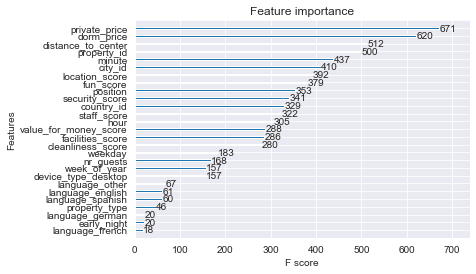

In [454]:
xgb.plot_importance(ranking_model)

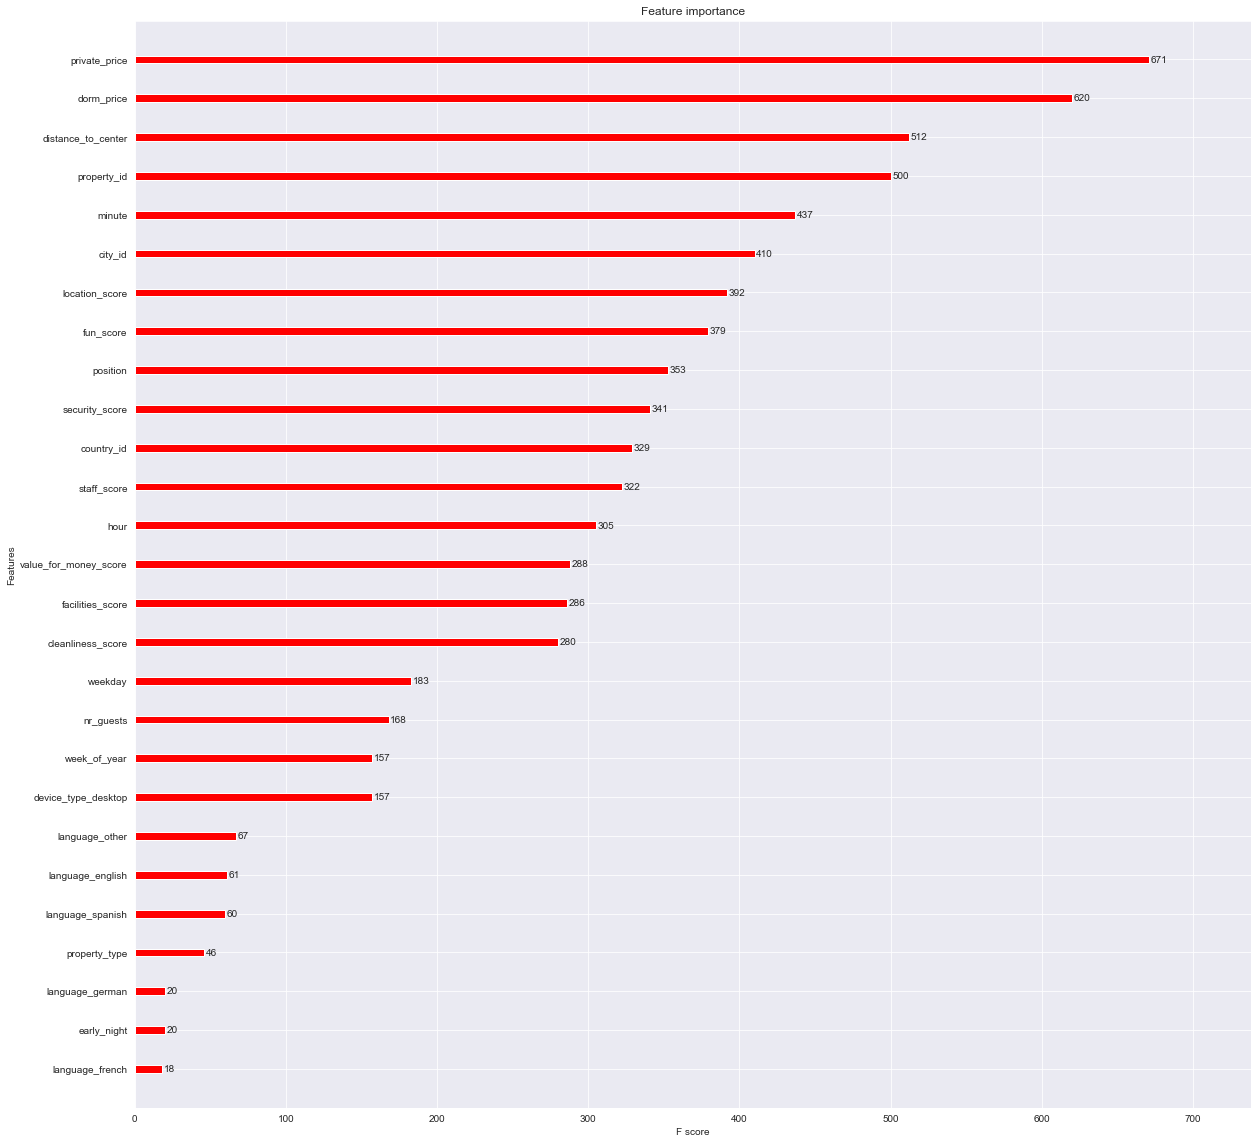

In [455]:
ax = xgb.plot_importance(ranking_model, color='red')
fig = ax.figure
fig.set_size_inches(20, 20)

### MAKING PREDICTIONS

In [456]:
pred = ranking_model.predict(D_test)
pred

array([ 0.8096472 ,  0.42975357,  0.01677722, ..., -1.4585977 ,
       -0.19940722,  0.30264616], dtype=float32)

#### PERSIST THE MODEL

In [458]:
import joblib

# Save the Model to file in the current working directory
joblib_file = "ranking_model.pkl"  
joblib.dump(ranking_model, joblib_file)

['ranking_model.pkl']

#### EVALUATING THE MODEL - NDCG

In [459]:
def dcg(y_score, y_true, k):
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])

    gain = 2 ** y_true - 1

    discounts = np.log2(np.arange(len(y_true)) + 2)
    return np.sum(gain / discounts)
    
#mean_ndcg = sum(ndcg(query) for query in queries) / len(queries)

dcg(Y_test,pred,10)

5.94504172772141

In [460]:
def dcg_at_k(r, k):
    r = np.asfarray(r)[:k]
    if r.size:
        return np.sum(np.subtract(np.power(2, r), 1) / np.log2(np.arange(2, r.size + 2)))
    return 0.


def ndcg_at_k(r, k):
    idcg = dcg_at_k(sorted(r, reverse=True), k)
    if not idcg:
        return 0.
    return dcg_at_k(r, k) / idcg

In [461]:
ndcg_at_k(pred,10)

0.09827923692316784